In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h2o

In [230]:
# data set cration

np.random.seed(2021)
n=5000

# independent variables
gender=['Female','Male']
d = pd.DataFrame({'gender':np.random.choice(gender, n)})

marital_status=['Single','Single','Single','Single','Married','Married','Married','Married','Divorced','Widowed']
d['marital_status']=[x for x in np.random.choice(marital_status,n)]

d['age']=[int(max(x,16)) for x in np.random.normal(50,15,n)]
d['distance']=[int(x) for x in np.random.chisquare(3,n)*10]
d['income']=[int(x) for x in np.random.lognormal(3,1,n)*1000]

# dependent variable calculation
d['number_of_visits']=1/d['distance']*10000+1/d['age']*1000+np.sqrt(d['income'])
d['number_of_visits'] = np.where((d['age'] < 30), d['number_of_visits']*2, d['number_of_visits']+20)
d['number_of_visits'] = np.where(d['gender']=='Male', d['number_of_visits']+d['distance'], d['number_of_visits']+d['age']/10)
# randomness addition
d['number_of_visits']=d['number_of_visits']+[int(x) for x in np.random.uniform(0,2000,n)]
d['number_of_visits']=(d['number_of_visits']/10).round(0)

# id
d.index.name='id'

In [154]:
d.head()

,gender,marital_status,age,distance,income,number_of_visits
id,,,,,,
0,Male,Widowed,75,5,123134,327.0
1,Female,Single,20,10,6396,294.0
2,Male,Widowed,41,26,20399,136.0
3,Female,Married,51,31,29297,213.0
4,Female,Married,55,29,49461,186.0


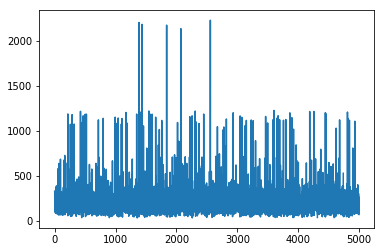

In [155]:
# target visualisation
plt.plot(d['number_of_visits'])

In [159]:
# h2o initialisation
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.2+13, mixed mode)
  Starting server from C:\Users\Ewela\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Ewela\AppData\Local\Temp\tmpq__d8fg9
  JVM stdout: C:\Users\Ewela\AppData\Local\Temp\tmpq__d8fg9\h2o_Ewela_started_from_python.out
  JVM stderr: C:\Users\Ewela\AppData\Local\Temp\tmpq__d8fg9\h2o_Ewela_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Belgrade
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_Ewela_j41tel
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.928 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [160]:
# data import
d=h2o.H2OFrame(d)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [162]:
# data split
train, valid, test = d.split_frame(ratios=[0.7,0.15],seed=19)

In [163]:
y='number_of_visits'
x=d.columns[:5]
x

['gender', 'marital_status', 'age', 'distance', 'income']

In [235]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [266]:
# reasonable gbm model
mgbm = H2OGradientBoostingEstimator(nfolds=10,ntrees=45,max_depth=4)
mgbm.train(x,y,train,model_id='first',validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [267]:
# results on training and testing data
print(mgbm.model_performance(train=True))
print(mgbm.model_performance(test))


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 3564.5881146882152
RMSE: 59.70417166905689
MAE: 49.608667005725636
RMSLE: 0.3747933524205017
Mean Residual Deviance: 3564.5881146882152


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 4067.6757427493008
RMSE: 63.778332862730906
MAE: 53.590175858358805
RMSLE: 0.39487089884080895
Mean Residual Deviance: 4067.6757427493008



In [248]:
# overfitted gbm model
mgbm2 = H2OGradientBoostingEstimator(ntrees=500,nfolds=10,max_depth=10)
mgbm2.train(x,y,train,model_id='overfit',validation_frame=valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [249]:
# results on training and testing data
print(mgbm2.model_performance(train=True))
print(mgbm2.model_performance(test))


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 543.4112675148831
RMSE: 23.311183314342564
MAE: 18.105465981232896
RMSLE: 0.16534334841570306
Mean Residual Deviance: 543.4112675148831


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 4879.555167593962
RMSE: 69.85381283504833
MAE: 58.50622967518567
RMSLE: 0.4376805899730214
Mean Residual Deviance: 4879.555167593962

